# Digital Twins of Microbiomes and General Ecosystems

https://www.science.org/doi/10.1126/sciadv.adj0400

Digital twins as a concept is increasingly relevant for modeling, exploring, understanding and exploiting complex natural systems. We demonstrate a new approach, that distills a generative model from observed 
sparse abundance profiles, i.e., gives us a digital twin for microbiomes, and is applicable to general systems. The tools are distributed as the *qbiome* package, which depends on the *quasinet* package.

The *quasinet* package currently works off-the-shelf only on linux-like systems. But is easily portable to other targets,
 consult installation instructions for other platforms at https://pypi.org/project/quasinet/. 

Contact: 

+ ishanu@paraknowledge.ai 
+ ishanu@uchicago.edu

---
# Table of Contents

- [Basic Installation](#Basic_Installation)
- [Data Format](#Data_Format)
    - [Data Format More Comments](#Data_Format2)
- [Quantization](#Quantizer)
- [Qnet Model of Digital Twins](#Qnet)
    - [Qsampling](#Qsampling)
    - [Qnet Training](#Qnet_Training)
- [Visualization](#Visualization)
- [Explore Structure of Qnet](#Explore_Structure)
- [Influence Network](#Influence_Network)
    - [Network Visualization](#Network_Visualization)
- [Forecast Microbiome Evolutionary Trajectories](#Forecast)
- [Phantom Patient Simulation](#Phantom_Patient)
- [Complexity of Digital Twins](#Complexity)

---

# Basic Installation <a name="Basic_Installation"></a>

```
pip install quasinet
pip install qbiome
```

For full functionality, `pygraphviz` and `graph-tool` is needed

## Usage `qbiome`

Load packages

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
from qbiome.qutil import qsmooth

# Loading Data

Next, load data. For this example, we use a dataset from Bokulich et. al 

- [Antibiotics, birth mode, and diet shape microbiome maturation during early life](https://doi.org/10.1126/scitranslmed.aad7121) 

The `qbiome` package includes helper methods `DataFormatter()`for processing data into the correct format for Qnet construction. If your source data is formatted differently, you may need to write your own preprocessing steps.

In [2]:
dirname = "example_data/"
data = (
    dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv"
)
meta = dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv"
base_tax = "Family"
base_tax = "Genus"
#base_tax = "Class"

formatter = DataFormatter()
data = formatter.load_data(
    fpath_data=data, fpath_meta=meta, taxon_name=base_tax, tax_dict={}
)

There are 504 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


## Data Format <a name="Data_Format"></a>

Our generative model or digital twin (Qnet) construction requires the numeric data to be quantized into levels (categorical data). Given abundance data in long-format (eg. produced by the above formatting), the `qbiome` package can quantize the data. You can indeed start from the following format, or write your own processor to get ypur data to the following format. One we have the data in teh following format, ether are tools in the package for automated quantization.

In [3]:
data.head()

,sample_id,subject_id,variable,week,value
58,MBSMPL0020-6-10,1,unclassified_Bacteria,27,0.032022
59,MBSMPL0020-6-10,1,Bacteroides,27,0.421525
60,MBSMPL0020-6-10,1,Bifidobacterium,27,0.366650
61,MBSMPL0020-6-10,1,unclassified_Bacteria,27,0.005058
62,MBSMPL0020-6-10,1,unclassified_Bacteria,27,0.002032


Select a biome to test/visualize forecasts. We set the first biome as an example.

In [4]:
biome=data.variable.values[1]
biome

'Bacteroides'

## Quantizer <a name="Quantizer"></a>

We can use `Quantizer()` methods (recommended) to process the data into the correct format for fitting the qnet.

By default, the `Quantizer()` quantizes the range of each variable into 5 levels; this can be modified by setting the `num_levels` parameter. The ordered levels are given categorical labels corresponding to the letters of the English alphabet, i.e. `A` corresponds to the lowest level of a given variable, `B` corresponds to the next lowest level, etc.

The optimal precision level for the quantization is a function of the data available for a given problem: for some problems, using higher values for `num_levels` will improve performance, but this does not seem to always be the case.

Note: After quantization, the Quantizer class allows for dequantization, which attempts to approximate the original numerical values from the quantized labels. A randomforest regressor comes into play here. The quantized (and then dequantized) data lacks the precision of the original data because quantization inherently introduces some  loss of detail. The `sklearn:RandomForestRegressor` is used to model and predict numerical values which is likely to have produced the quantized symbols. This dequantization capability is used implicitly in forecasts.

In [5]:
quantizer = Quantizer(num_levels=10)
qnet_orchestrator = QnetOrchestrator(quantizer)
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

## More Data Format Comments <a name="Data_Format2"></a>

If processing your own data, you will need to generate:
- a wide form (tabular) numpy array containing the quantized abundances for each subject (`label_matrix` - note that missing values should be filled with the empty string `''`), and 
- an array of the corresponding names of each variable in the data (`features`)
    - for usage with other `qbiome` functions, it is recommended to name variables are according to the naming convention `TAXA_TIMEPOINT`, eg. `Actinobacteria_1` refers to the level of Actinobacteria at week 1

In [6]:
display(features)
display(label_matrix)

Index(['Anaerostipes_1', 'Anaerostipes_2', 'Anaerostipes_3', 'Anaerostipes_5',
       'Anaerostipes_6', 'Anaerostipes_7', 'Anaerostipes_8', 'Anaerostipes_9',
       'Anaerostipes_10', 'Anaerostipes_13',
       ...
       'unclassified_Bacteria_85', 'unclassified_Bacteria_86',
       'unclassified_Bacteria_87', 'unclassified_Bacteria_88',
       'unclassified_Bacteria_89', 'unclassified_Bacteria_90',
       'unclassified_Bacteria_93', 'unclassified_Bacteria_96',
       'unclassified_Bacteria_97', 'unclassified_Bacteria_98'],
      dtype='object', length=1151)

array([['A', '', 'E', ..., '', 'C', ''],
       ['C', '', '', ..., '', 'H', ''],
       ['', '', '', ..., '', 'B', ''],
       ...,
       ['A', 'J', '', ..., 'D', '', ''],
       ['D', '', '', ..., '', '', ''],
       ['A', '', '', ..., '', '', 'E']], dtype='<U1')

Lets list the taxa present in this dataset:

In [7]:
TAXA = list(data.variable.value_counts().index.values)
TAXA

['unclassified_Bacteria',
 'Bifidobacterium',
 'Streptococcus',
 'Bacteroides',
 'Veillonella',
 'Clostridium sensu stricto 1',
 '[Ruminococcus] gnavus group',
 'Erysipelatoclostridium',
 'Haemophilus',
 'Salmonella',
 'Blautia',
 'Faecalibacterium',
 'Flavonifractor',
 'Intestinibacter',
 'Anaerostipes',
 'Incertae Sedis']

# A Brief Note on the Digital Twin Model Framework (Qnet) <a name="Qnet"></a>

+ A Qnet is a data-inferred model of a *very* high dimesional condtional distribution. Denoting $x$ as an observed abundance profile, i.e., $x = x_1,\cdots, x_i, \cdots, x_n$, the Qnet identifies a model $\Phi$ such that:


$$
\Phi_i(x_{-i}) \textrm{ is the distribution of variable } x_i \textrm{ over the alphabet } \Sigma_i
$$

+ Note $x$ is a realization of a sequence of random variables $X_1, \cdots X_n$, and typically $\vert \Sigma_i \vert < \infty$. 

+ Here, $x_{-i}$ denotes the observation profile with the value for $x_i$ missing or deleted. In general, for computing a predicted distribution for $x_i$, many entries in $x$ may be missing or delected. 

+ Importantly, we can have no observations, and still legitimately ask: what is the best estimate for the distribution for $x_i$, if I have no information on the other variables. If we do have such information, the estimate changes since the variables are NOT independent, which is the whole point of inferring the Qnet.

### Q-sampling  <a name="Qsampling"></a>

This sampling process, especiially the ability to work with missing data seamlessly, can be used to forecast data missing because it is in future, even with sparse observations in the past. And we can build observation profiles for patients we have never observed (phantom patients, patients that are entirely simulated, but realistically). 

Note. We show in the paper that `qsampling` is just Gibb's sampling, but "better".

### Complexity of Inferred Qnets

The Qnet complexity is decided by the data since the individual predictors which are conditional inferrence trees are not constrained to any preset limits in their depth. Thus, the complexity of the trees, and the number of independent trainable paameters are functions of the intrinsic complexity of the data iteself.

### Intrinsic Distance Metric Induced by the Qnet

We will not discuss the **q-distance** at depth here, but it is a key takeaway from this approach, that we can identify a "right" metric for comparing how similar or different two observed profiles are. We show in the paper that the q-distance defined as:

$$
\theta(x,y) = \mathbf{E}_i [ J^{1/2}(\Phi_i(x_{-i}),\Phi_i(y_{-i}))       ]
$$

is a metric that scales as the log-likelihood of the spontaneous jump $x \rightarrow y$, where $x,y$ are two observed profiles, and $J^{1/2}$ is the square-root of Jensen-Shannon divergence.

---

# Learning the digital twin (Qnet) model from Data  <a name="Qnet_Training"></a>

Qnet is our digital twin model, comprising a recursive forest of predictors. Each predictor aims to model one variable (feature or column) as a function of the remining features or columns. Because each predictor can involve many of the other features, the overall representation is recursive. In this implementation each of these individual predictors are conditional inference trees, and in the overall Qnet, each non-leaf node in the tree is hyperlinked to the predictor (tree) of the variable that this node is labeled with. This leads to a a recursive expansion by jumping to trees from leaves, and more trees from each inner node of the next tree.

Qnet learning requires the variable names (`features`) and quantized data (`label_matrix`). 
The key hyperparameter is  `alpha`  passed to `quasinet.qnet` specifies the statsitical CI for the construction of the confidence inference trees.

- `min_samples_split`: Minimum samples required for a split
- `alpha`: Threshold value for selecting feature with permutation tests (smaller values correspond to shallower trees)

In [ ]:
%%time
qnet_orchestrator.train_qnet(
    features, label_matrix, alpha=0.3, min_samples_split=2, out_fname=None
)
qnet_orchestrator.save_qnet("example_qnet_"+base_tax+".pkl",GZIP=True)

---
# Visualization <a name="Visualization"></a>

Since the Qnet is a recursive forest of predictors (here conditional inference trees), overall visualization of the model is hard.
+ We can visualize these trees themselves to inspect model structure:

In [8]:
from quasinet.qnet import load_qnet
outdirname = 'trees_'+base_tax
modelpath="example_qnet_"+base_tax+".pkl.gz"
model=load_qnet(modelpath,gz=True)
model.viz_trees(tree_path=outdirname,big_enough_threshold=1,format='png',
                remove_newline=True,remove_dotfile=True)

Note that some trees may include variables at a later time point (as by default, there is no modeling restriction on temporal relations). However, for forecasting and hypothesis generation, we impose temporal restrictions that will exclude these non-causal interactions.

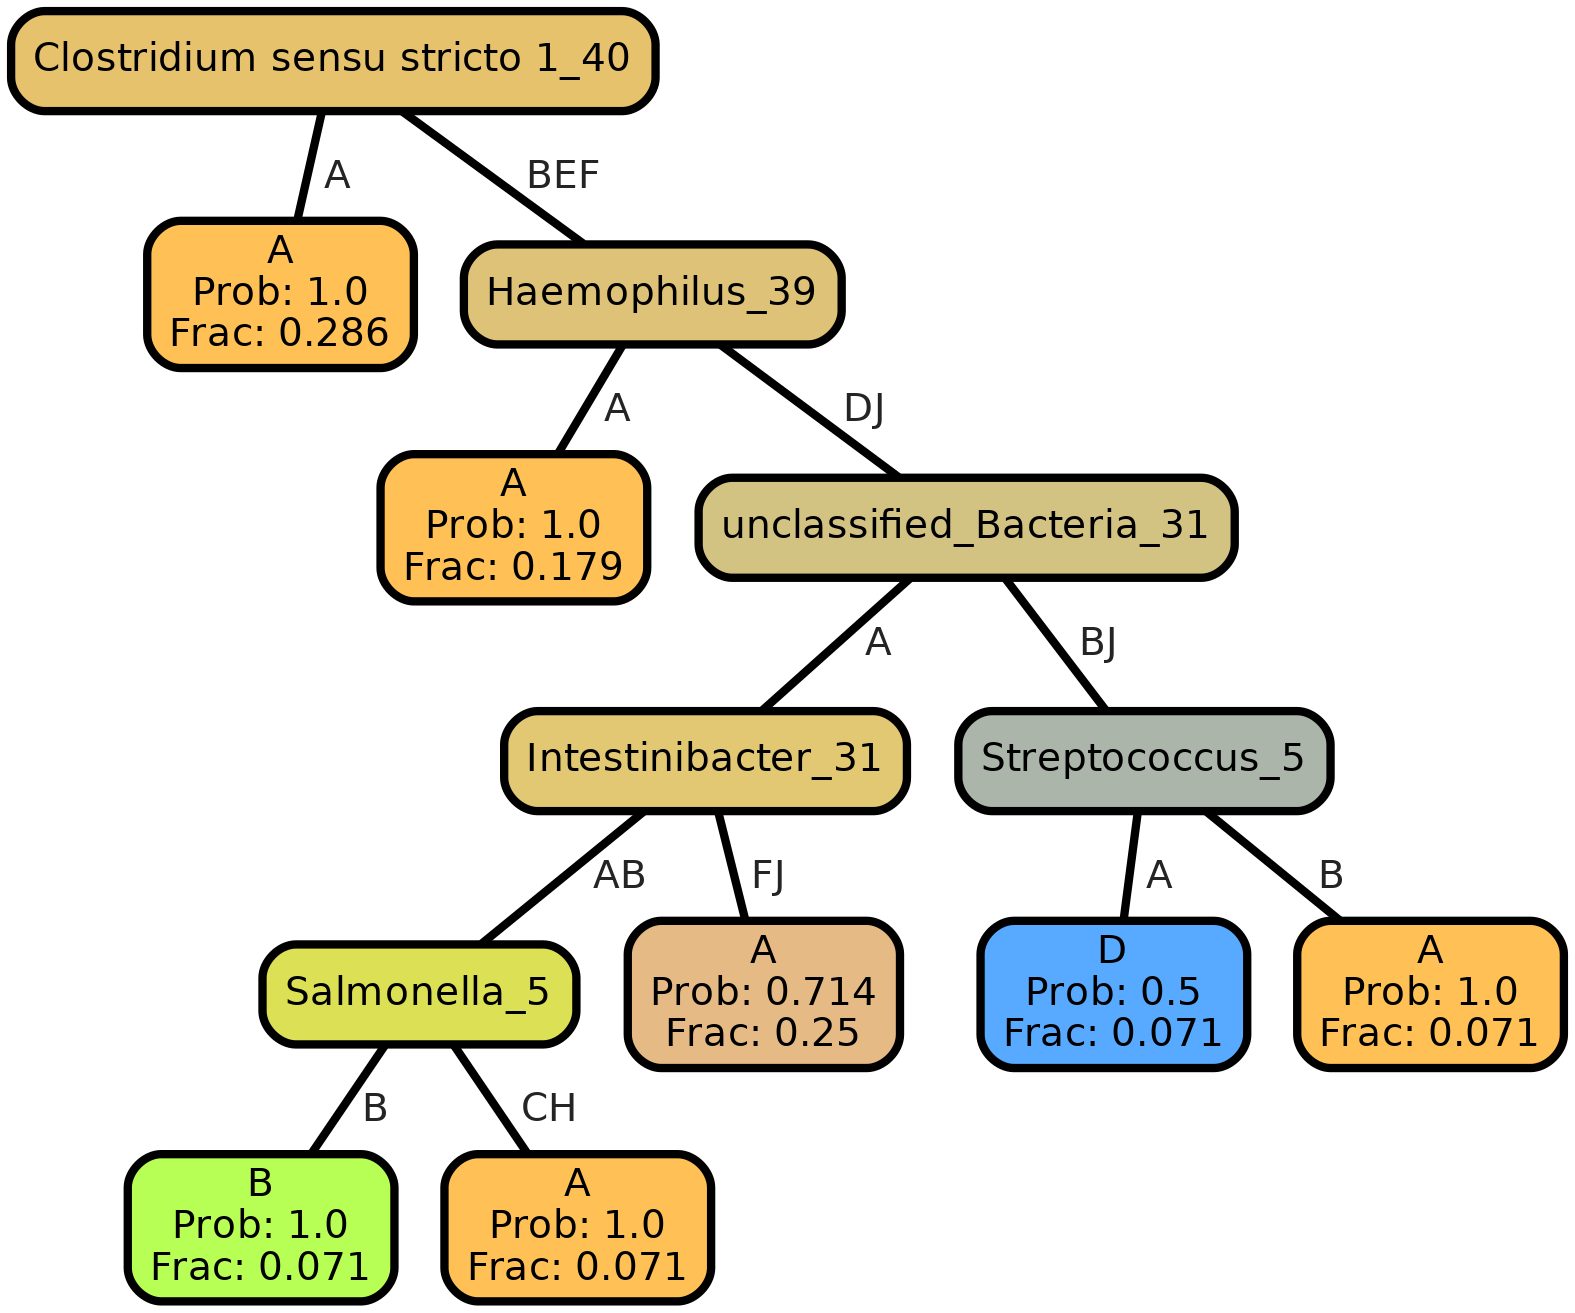

In [9]:
from IPython.display import Image
import glob
Image(filename=glob.glob(outdirname+"/*png")[0])

## Explore Structure of the Inferred Digital Twin <a name="Explore_Structure"></a>

As stated above, the recursive structure of the Qnet is hard to visualize. Note that:

+ It is not a network with nodes and links. Each predictor is a conditional inference tree. One could draw an edge between variable A to variable B if variable A is used as a feature in the predictor for variable B. But this is a very lossy representation.  

We can inspect this assymetric **reduced feature-level** network as follows:  


In [ ]:
from quasinet.export import QnetGraphExporter
QnetGraphExporter(model,base_tax+'.dot',threshold=0).export()
# fix names that will cause problems in graphviz, namely special charcaters in node names and spaces
! sed -i -e 's/\[Ruminococcus\] gnavus group/Ruminococcus_gnavus_group/g' -e 's/Clostridium sensu stricto /Clostridium_sensu_stricto/g' -e 's/Incertae Sedis/Incertae_Sedis/g' Genus.dot

In [ ]:
! python ./getNetworkPlot_biome.py Genus.dot -o biome.png  -v 0 -a 0.7 -c Blues -E True -e 1.13 -A 0
from IPython.display import Image
Image(filename='biome.png')

# `LOMAR` Network: Inspect Positive and Negative Regulation <a name="Influence_Network"></a>

Another possible visualization or representation is distilling average positive and negative regulation relationships between pairwise taxa or variables (averaging out time information). We call these the LOMAR coefficients (Local Marginal Regulation), which estimates the degree of up/down regulation on tax B by unit changes in taxa A. LOMAR coefficients are asymmetric (i.e. with a specified source and target), and *might* indicate causal interactions between taxa. We compute these using `Hypothesis()` methods in the package, the name arising from teh fact that a large LOMAR coefficient is a "hypothesis" suggested by the digital twin for strong interaction between taxa.

The `causal_constraint` parameter constrains which time points for source can be considered as inputs when computing source to target influences. If causal_constraint is `None`, there are no restrictions. Otherwise, only sources that are at least `causal_constraint` units of time prior to the target may be considered. Note that negative values are allowed, and may be of use if there is possible imprecision in time measurement in the data.


In [10]:
qnet_orchestrator.load_qnet("example_qnet_"+base_tax+".pkl.gz",GZIP=True)
hypothesis = Hypothesis(
    quantizer=quantizer,qnet_orchestrator=qnet_orchestrator, detailed_labels=True
)

In [11]:
hypothesis.causal_constraint = -2
hypothesis.no_self_loops = False

hypothesis.get(time_start=1, time_end=5)
hypothesis.to_dot("hypothesis_1_10.dot")
hypothesis.hypotheses.sort_values("src")

100%|███████████████████████████████████████████| 16/16 [00:08<00:00,  1.85it/s]


,src,tgt,time_tgt,lomar,pvalue
66,Anaerostipes,Blautia,1.0,-3.209021e-01,5.448751e-55
63,Anaerostipes,Intestinibacter,1.0,7.836314e-02,0.000000e+00
51,Anaerostipes,Clostridium sensu stricto 1,5.0,1.935361e+01,0.000000e+00
14,Anaerostipes,Erysipelatoclostridium,1.0,-3.268800e-01,0.000000e+00
55,Anaerostipes,Flavonifractor,1.0,-1.977879e+01,6.159613e-201
...,...,...,...,...,...
16,unclassified_Bacteria,Erysipelatoclostridium,5.0,-2.699172e-01,1.091799e-194
46,unclassified_Bacteria,Anaerostipes,1.0,1.296034e-01,0.000000e+00
44,unclassified_Bacteria,Salmonella,5.0,7.044764e-01,3.729445e-57
5,unclassified_Bacteria,Streptococcus,1.0,-2.754793e+14,8.034291e-68


## Visualizing LOMAR or Regulation Network <a name="Network_Visualization"></a>

If we build the visulaization using the `network()` method, we see that positive and negative regulations are indicated separately, --> indicating upregulation in the direction specified, while --| indicating downregulation in the direction specified. Thickness of the edges indicate magnitude of the LOMAR coefficients.

In [ ]:
# if graph-tool is installed
from qbiome.network import Network
Network('hypothesis_1_10.dot',outfile='net.png').get()
# Can also use the external prog
#! python3.7 plotNetwork.py >& /dev/null
from IPython.display import Image
Image(filename='net.png')

# Forecast microbiome evolutionary trajectories <a name="Forecast"></a>

Next, we forecast abundances from a given initial time point, using the `Forecaster()`.
Note that the `forecast_data()` method uses data in the form of a quantized numpy array (here, the `label_matrix` from above). We also specifiy the start time (start-week, SW) of the forecast time, the data before that is assumed to be known.

In [12]:
# forecast from time SW
SW = 9
#qnet_orchestrator = QnetOrchestrator(quantizer)
#qnet_orchestrator.load_qnet("example_qnet.pkl.gz",GZIP=True)
forecaster = Forecaster(qnet_orchestrator)
# can specify an end week or default to the max end week in the data
forecasted_ = forecaster.forecast_data(label_matrix, start_week=SW).assign(
    source="forecasted"
)

The result is a long-form data frame of relative abundances for each subject. 

In [13]:
DF = forecasted_
SUBJECTS = DF.subject_id.value_counts().index.values
DF

DF_pop = DF.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()
DF_data = data.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()

For comparison, we plot the forecasted vs. actual data (averaged over all subjects):

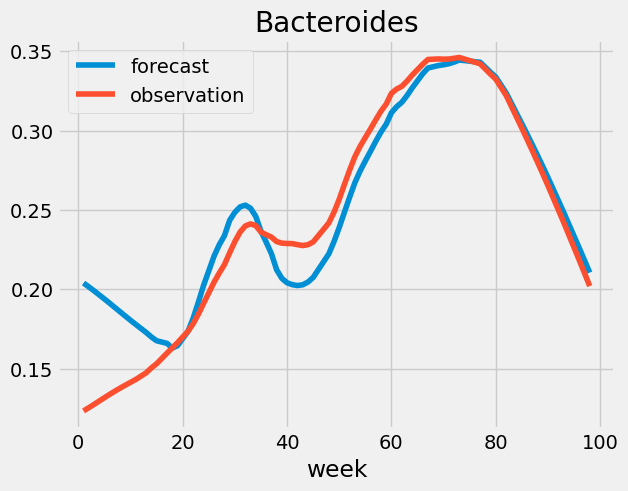

In [14]:
DF_pop = DF.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()
DF_data = data.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()

DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)

ax = DF_pop_smooth[biome].plot(label="forecast")
DF_data_smooth[biome].plot(ax=ax, label="observation")
ax.set_title(biome)
ax.legend()

Here is a comparison plot for an individual subject:

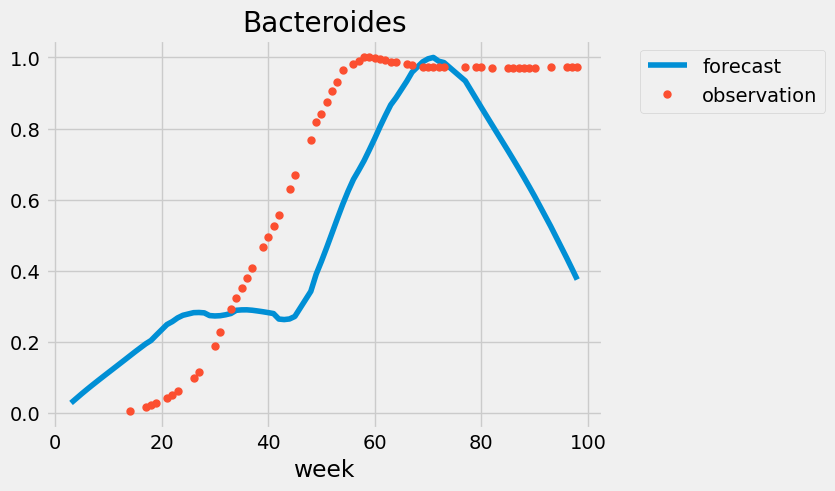

In [15]:
SID = "11"
DF_pop = (
    DF[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_data = (
    data[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.4,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.6,
)

var = biome
ax = DF_pop_smooth[var].plot(label="forecast")
DF_data_smooth[var].plot(ax=ax, style="o", ms=5, label="observation")
ax.set_title(biome)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

## Generate Ecosystem Evolution for a Non-existant "Phantom" Patient <a name="Phantom_Patient"></a>

If we want to forecast the trajectory of a new subject, we just read in their data, quantize, and forecast. 
We can also do this forecast for a "phantom" subject, one which does not actually exist, but is a realistic simulation of a possible patient or subjecty. This phantom patient is initialized with  some random observations or even no observations for any of the taxa at any of the weeks.

Here we demonstrate by randomly generating a "phantom" subject and forecasting from week SW.

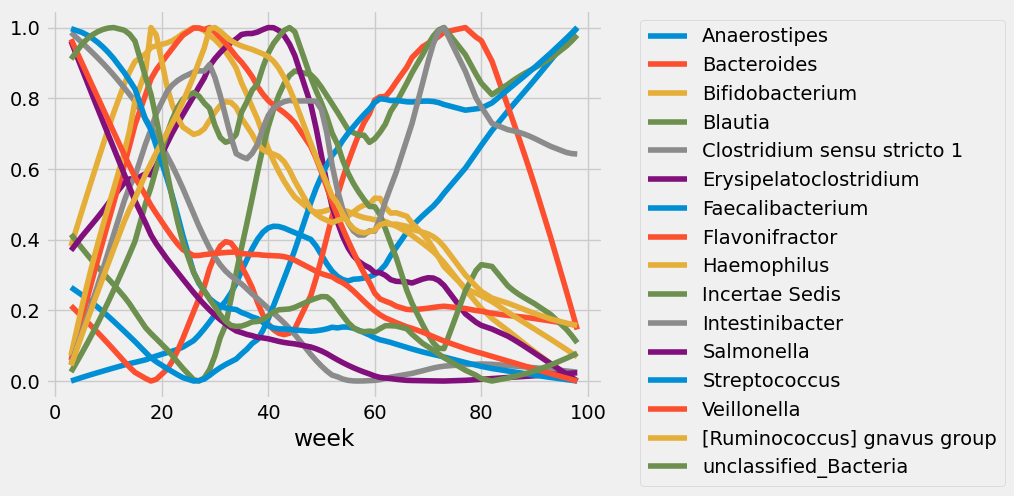

In [16]:
new_subject = pd.DataFrame(
    {
        "week": [0] * len(TAXA),
        "variable": TAXA,
        "value": [np.nan]*len(TAXA),
    }
)
new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, start_week=SW, subject_id=[12345]
)

df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.3,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

### Only predict 40 weeks and later, when we have a profile observed at 20 weeks

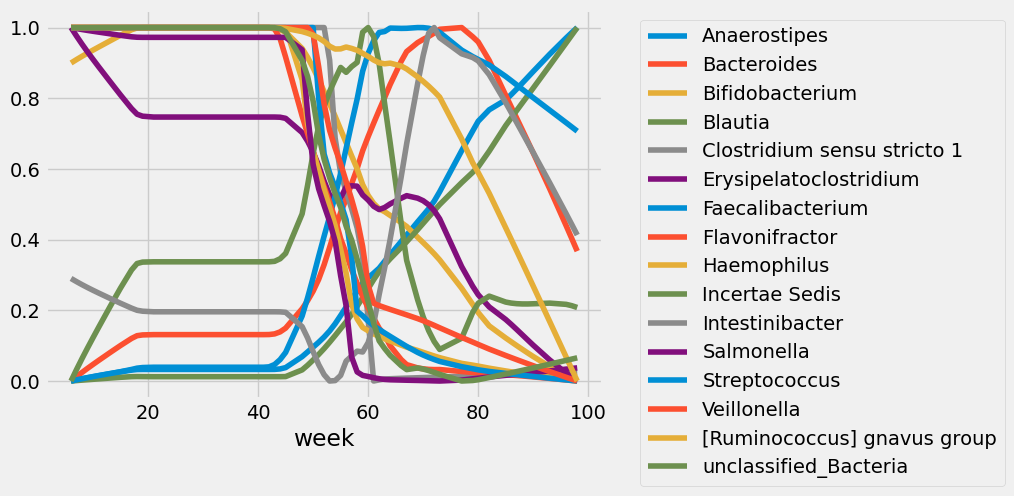

In [17]:
new_subject = pd.DataFrame(
    {
        "week": [20] * len(TAXA),
        "variable": TAXA,
        "value": np.random.rand(len(TAXA)),
    }
)


new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data( 
    new_subject_matrix, start_week=SW+40, subject_id=[12345], n_samples=50
)

df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.3,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Complexity of Inferred Digital Twin <a name="Complexity"></a>

There are many different methods of ideas to measure complexity. One apprach is to note the number of independent trainable parameters. This is adaptive for the Qnet since the individual tree deptsh are automatically identified.

In [19]:
from quasinet.utils import numparameters
numparameters(model)

10271

In [20]:
new_subject = pd.DataFrame(
    {
        "week": [20] * len(TAXA),
        "variable": TAXA,
        "value": np.random.rand(len(TAXA)),
    }
)


new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)


In [21]:
new_subject_matrix

array([['', '', '', ..., '', '', '']], dtype='<U1')

In [24]:
from quasinet.qsampling import qsample
qsample(label_matrix[0],model,steps=1000)

array(['A', 'A', 'E', ..., '', 'H', 'E'], dtype='<U1')

In [25]:
! cp /home/ishanu/Dropbox/H.dat .

In [26]:
! /home/ishanu/Dropbox/ZED/Research/data_smashing_/bin/embed -f H.dat


 78.012849s wall, 882.500000s user + 0.570000s system = 883.070000s CPU (1132.0%)


In [27]:
! ls -lhtr

total 58M
drwxrwxr-x. 4 ishanu ishanu 4.0K Apr 10 09:45 example_data
-rw-rw-r--. 1 ishanu ishanu  470 Apr 10 09:45 README.md
drwxrwxr-x. 7 ishanu ishanu 4.0K Apr 10 09:45 publication_examples
drwxrwxr-x. 2 ishanu ishanu 120K Apr 10 11:53 dotfiles
-rw-rw-r--. 1 ishanu ishanu 467K Apr 11 09:09 basic-example.ipynb
-rw-rw-r--. 1 ishanu ishanu 7.7M Apr 11 09:09 example_qnet_Order.pkl.gz
-rw-rw-r--. 1 ishanu ishanu 7.5M Apr 11 09:09 example_qnet_Genus.pkl.gz
-rw-rw-r--. 1 ishanu ishanu 8.0M Apr 11 09:09 example_qnet_Family.pkl.gz
-rw-rw-r--. 1 ishanu ishanu 1.5K Apr 11 09:09 getLink.py
drwxrwxr-x. 2 ishanu ishanu  20K Apr 11 09:09 trees_Order
drwxrwxr-x. 2 ishanu ishanu  20K Apr 11 09:09 trees_family
-rw-rw-r--. 1 ishanu ishanu 4.7M Apr 11 09:19 example_qnet_Class.pkl.gz
drwxrwxr-x. 2 ishanu ishanu  60K Apr 11 09:20 trees_Class
-rw-rw-r--. 1 ishanu ishanu 6.0K Apr 11 11:23 getNetworkPlot_biome.py
-rw-rw-r--. 1 ishanu ishanu 3.1K Apr 11 11:28 hypothesis_1_5.dot
-rw-rw-r--. 1 ishanu ishanu   9

In [40]:
E=pd.read_csv('outE.txt',sep=' ',header=None).T.dropna(how='all')
E.columns=['x'+str(i) for i in E.columns]
E.to_csv('E.csv',index=None,header=None,sep=' ')

(0.025, 0.06)

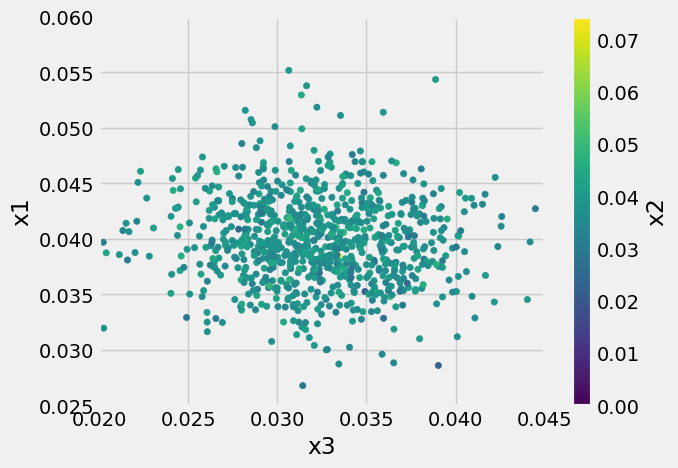

In [39]:
ax=E.plot.scatter(x='x3',y='x1',c='x2')
ax.set_xlim(0.02,0.045)
ax.set_ylim(0.025,0.06)

In [41]:
from sklearn.manifold import TSNE

In [52]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=10).fit_transform(E)

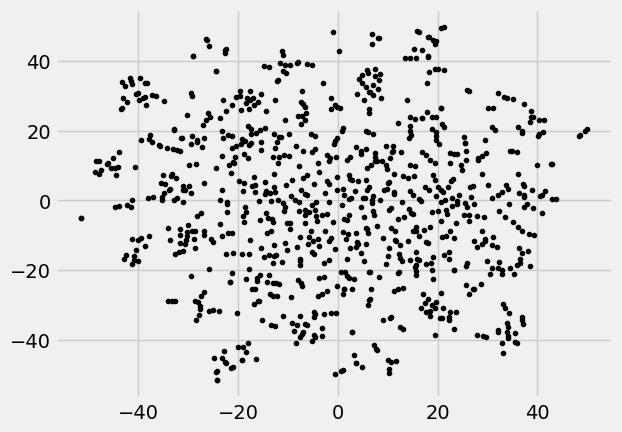

In [53]:
plt.plot(X_embedded[:,0],X_embedded[:,1],'k.')

In [50]:
X_embedded

array([[ -8.9572315, -10.576432 , -22.78465  ],
       [  3.2040944, -26.678167 ,  -0.9444851],
       [  2.307871 , -17.13752  , -14.665135 ],
       ...,
       [ 16.72696  ,  13.856789 , -11.735522 ],
       [  9.007917 ,  17.523863 ,  -4.971742 ],
       [  6.2549314,   5.6659155, -22.789755 ]], dtype=float32)

In [59]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


In [108]:
from sklearn import manifold
n_neighbors = 5  # neighborhood which is used to recover the locally linear structure
n_components = 3  # number of coordinates for the manifold
params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}

In [109]:
lle_standard = manifold.LocallyLinearEmbedding(method="modified", **params)
X_embedded = lle_standard.fit_transform(E)


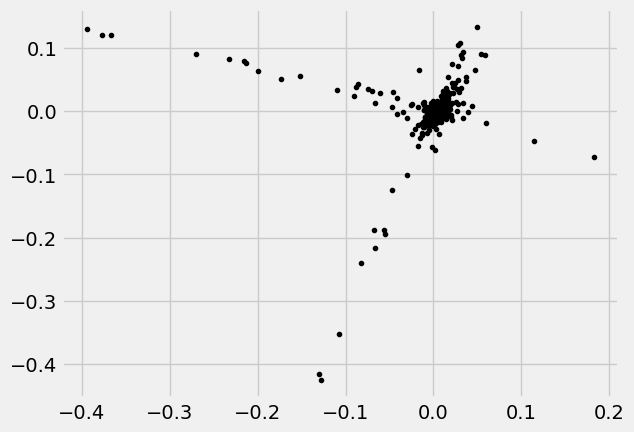

In [110]:
plt.plot(X_embedded[:,0],X_embedded[:,1],'k.')

In [111]:
X_embedded

array([[ 7.14121202e-03,  6.55141601e-03, -3.66514538e-03],
       [ 1.65152105e-03, -3.65417942e-03, -8.42497568e-03],
       [ 4.66341343e-03,  1.76953403e-03,  8.83066955e-03],
       ...,
       [ 7.83967942e-03,  4.64342890e-03, -6.51102011e-03],
       [ 3.63864818e-03, -2.98687560e-04, -2.83521513e-03],
       [ 3.88838634e-03, -1.78083673e-03, -5.52992968e-06]])

In [112]:
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker
def plot_3d(points):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    col = ax.scatter(x, y, z, s=30, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)

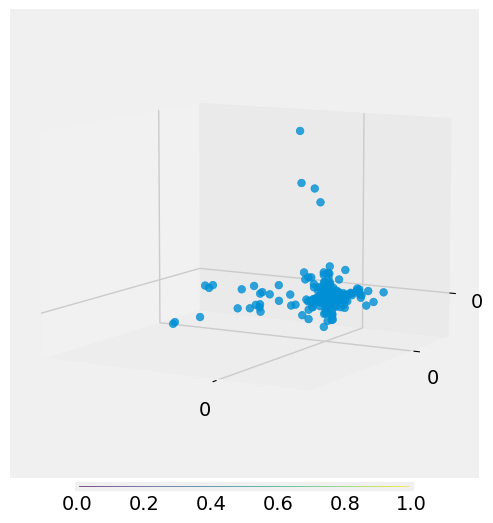

In [113]:
plot_3d(X_embedded)

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit(E)

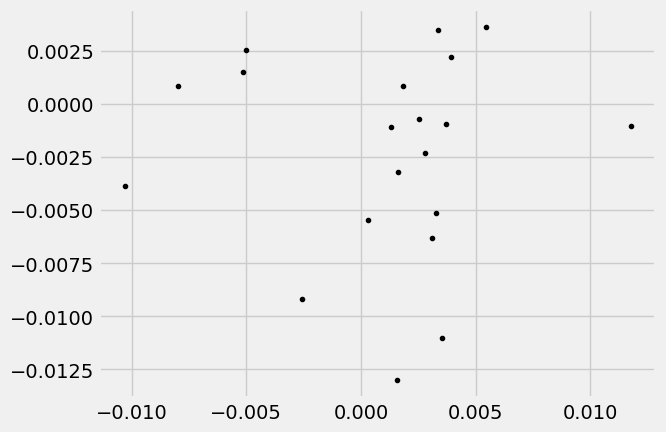

In [125]:
X_embedded = pca.transform(X2)
plt.plot(X_embedded[:,0],X_embedded[:,1],'k.')

In [217]:
E_=pd.concat([E.iloc[(i-1)*20:20*i,:2].assign(num=i) for i in range(45)])

In [229]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=20,covariance_type='diag',n_init=10,max_iter=1000).fit(E_.drop('num',axis=1))
#bgm.means_

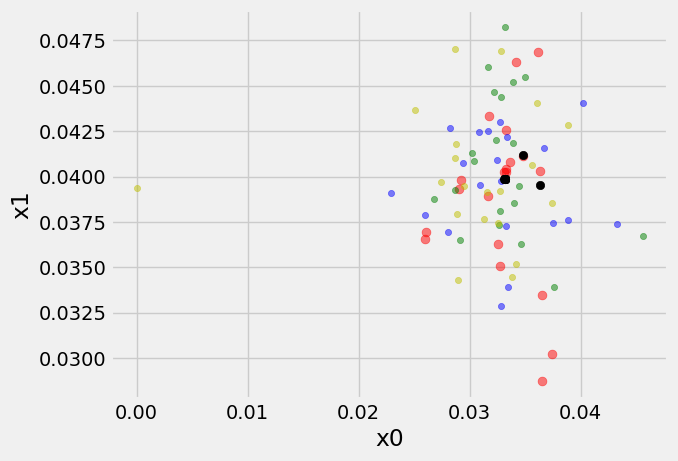

In [230]:
ax=E_[E_.num==1].plot.scatter(x='x0',y='x1',color='r',alpha=.5,s=40)
E_[E_.num==2].plot.scatter(ax=ax,x='x0',y='x1',color='b',alpha=.5)
E_[E_.num==3].plot.scatter(ax=ax,x='x0',y='x1',color='g',alpha=.5)
E_[E_.num==4].plot.scatter(ax=ax,x='x0',y='x1',color='y',alpha=.5)
plt.scatter(bgm.means_[:,0],bgm.means_[:,1],color='k')

In [203]:
m=2
E_=pd.concat([E.iloc[(i-1)*20:20*i,:m].assign(num=i) for i in range(45)])

X=pd.concat([pd.DataFrame(E_[E_.num==i+1].drop('num',axis=1).values.reshape(1,20*m).squeeze()).T for i in range(44)])

In [204]:
X

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.034794,0.041160,0.026005,0.036568,0.033256,0.040390,0.036165,0.046849,0.033259,0.042568,...,0.033631,0.040810,0.029232,0.039818,0.032698,0.035079,0.037399,0.030249,0.031640,0.038927
0,0.036647,0.041593,0.029407,0.040769,0.033311,0.042198,0.031664,0.042497,0.030830,0.042455,...,0.037473,0.037429,0.028066,0.036940,0.025982,0.037903,0.032851,0.039736,0.032423,0.040932
0,0.032623,0.037320,0.032830,0.044369,0.030422,0.040856,0.032152,0.044676,0.033964,0.038562,...,0.033897,0.045205,0.045596,0.036744,0.029075,0.036520,0.034397,0.039481,0.034615,0.036297
0,0.028710,0.047022,0.028695,0.041000,0.028931,0.034279,0.034188,0.035211,0.032770,0.046941,...,0.025085,0.043652,0.031536,0.039166,0.028764,0.041773,0.028893,0.037928,0.032726,0.039179
0,0.036717,0.036832,0.031357,0.032838,0.027219,0.036414,0.038054,0.034536,0.033892,0.042229,...,0.032787,0.039283,0.033790,0.028611,0.027338,0.041954,0.039633,0.041329,0.031246,0.035911
0,0.039599,0.040774,0.040340,0.032934,0.030001,0.036252,0.030907,0.038236,0.030668,0.041853,...,0.024702,0.040957,0.038940,0.042936,0.040597,0.040711,0.026096,0.043488,0.028767,0.041606
0,0.027994,0.040873,0.025485,0.042193,0.037514,0.044263,0.037430,0.042678,0.035165,0.033902,...,0.034508,0.045213,0.036790,0.041634,0.029615,0.034807,0.037486,0.038169,0.032270,0.037572
0,0.033862,0.043302,0.035143,0.041627,0.024822,0.040418,0.024288,0.046971,0.036808,0.043590,...,0.034383,0.039037,0.033559,0.043930,0.030154,0.038431,0.028424,0.029624,0.033072,0.041068
0,0.030104,0.039425,0.035237,0.040496,0.031010,0.031198,0.027788,0.044529,0.035112,0.037442,...,0.033125,0.039698,0.025952,0.039017,0.029247,0.042766,0.035222,0.045713,0.027390,0.051116
0,0.036125,0.042038,0.032082,0.042881,0.030939,0.032484,0.031840,0.037902,0.037403,0.036940,...,0.037435,0.039176,0.033834,0.040142,0.030768,0.044262,0.030593,0.042443,0.033200,0.041507


In [206]:
E_

,x0,x1,num
0,0.034794,0.041160,1
1,0.026005,0.036568,1
2,0.033256,0.040390,1
3,0.036165,0.046849,1
4,0.033259,0.042568,1
...,...,...,...
875,0.038873,0.036728,44
876,0.032761,0.033962,44
877,0.035230,0.038514,44
878,0.031979,0.039867,44


<Axes: xlabel='x0', ylabel='x1'>

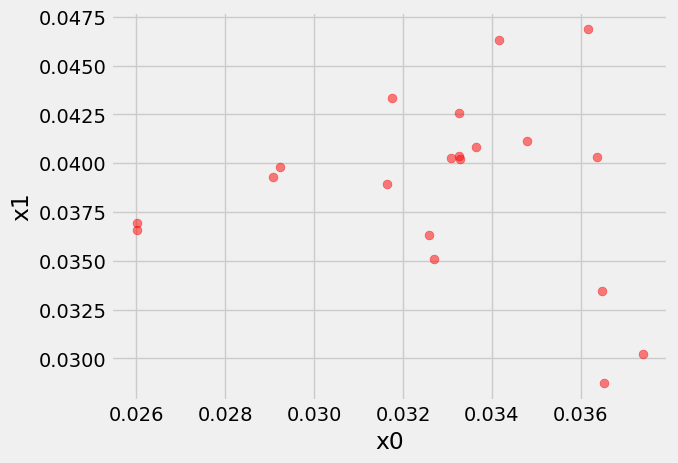

In [244]:
E_[E_.num==1].plot.scatter(x='x0',y='x1',color='r',alpha=.5,s=40)
#E_[E_.num==2].plot.scatter(ax=ax,x='x2',y='x1',color='b',alpha=.5)
#E_[E_.num==3].plot.scatter(ax=ax,x='x2',y='x1',color='g',alpha=.5)
#E_[E_.num==4].plot.scatter(ax=ax,x='x2',y='x1',color='y',alpha=.5)


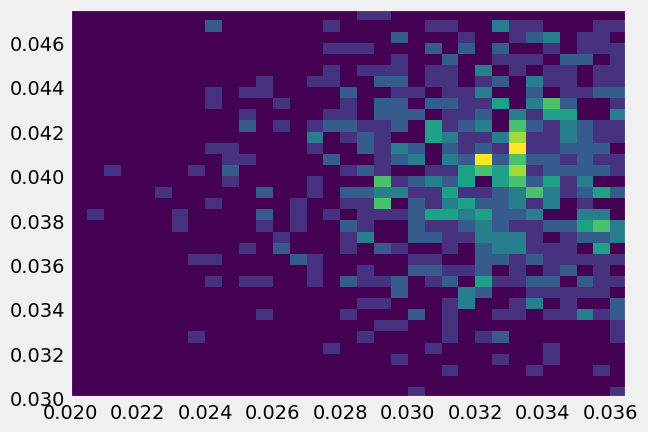

In [248]:
#bins=[30,30]
H,xedges,yedges=np.histogram2d(E.x0,E.x1, bins=(np.arange(0.02,0.037,0.0005),np.arange(0.03,0.048,0.0005)))
H=H.T
#plt.imshow(H, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
X, Y = np.meshgrid(xedges, yedges)
plt.gca().pcolormesh(X, Y, H)

In [412]:
from sklearn.neighbors import KernelDensity
N=100
x0_range = np.linspace(E['x0'].min(), E['x0'].max(), N)
x1_range = np.linspace(E['x1'].min(), E['x1'].max(), N)
#x2_range = np.linspace(E['x2'].min(), E['x2'].max(), N)
X0, X1= np.meshgrid(x0_range, x1_range)#,x2_range)
xy = np.vstack([X0.ravel(), X1.ravel()]).T#, X2.ravel()]).T
kde = KernelDensity(
        bandwidth=0.0004, metric="euclidean", kernel="gaussian", algorithm="ball_tree"
    )
kde.fit(E[['x0','x1']])#,'x2']])
Z = np.exp(kde.score_samples(xy))
Z=Z.reshape(X1.shape)

<Axes: xlabel='x0', ylabel='x1'>

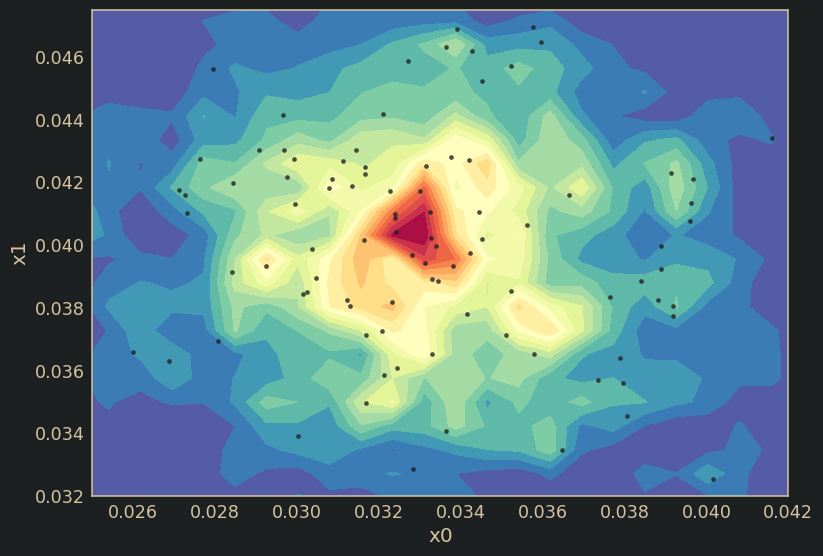

In [413]:
from jupyterthemes import jtplot
jtplot.style()
plt.figure(figsize=(8, 6))
ax=plt.gca()
plt.contourf(X0, X1, Z, levels=20, cmap=plt.cm.Spectral_r)
plt.gca().set_xlim(0.025,0.042)
plt.gca().set_ylim(0.032,0.0475)
E_.sample(100).plot.scatter(ax=ax,x='x0',y='x1',color='k',alpha=.8,s=10)
